## Gradient Project

V4 of the gradient project analysis (updated Feb 21 2024)  

Update to calculate on SSTA  
Save all of the output into dictionaries that are specific to each model  
Ensure that we are using all unique models  
Cut off data after 2022  

Per Haibo conversation: save the files out once the trends have been calculated; calculate the jump between the end and start times for the concatenation

Other potential updates:  
* Make some of the variables universal so that you only have to set them once (e.g., start time and end time)  
* Check that the scenario models span the full time that we need

In [1]:
%reset -f

In [2]:
%load_ext autoreload

In [3]:
%reload_ext autoreload
%autoreload 2

In [27]:
# initialising the environment

# analysis functions
import numpy as np
import xarray as xr
from math import exp, pi, sin, sqrt, log, radians, isnan
from scipy.stats import linregress
import cftime
import pandas as pd
import nc_time_axis
import random

# systems functions
import sys
from collections import defaultdict
import os

# plotting functions
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

# my own functions
from modelchecks_hb import lat_lon_res_Eq

# Classes

## ModelInput class

In [5]:
class ModelInput:
    def __init__(self, modelID):
        '''
        Takes the input of a modelID (in this case URL), reads in the data and checks the coordinates (makes sure it's lat and lon)
        :param modelID: A unique ID for the model in the form of an openDAP url or in the form of the dataset itself (to handle the cases where models have been concatenated)
        '''
        self.modelID = modelID
        self.ds = self.ExecAllSteps()
        
    
    # starting by assuming I will be putting the URLs in directly; ultimately move to some kind of dictionary
    def LoadData(self, modelID):
        '''
        Loads the data from the openDAP server
        '''
        try:
            
            # checking if we are dealing with a url or dealing with the dataset itself
            if isinstance(modelID, str):
                self.ds = xr.open_dataset(self.modelID)
            
            else:
                self.ds = modelID
                
            # print('Successful data loading')
            
        except Exception as e:
            print(f'Error loading data for model {self.modelID}: {e}')
        
    # doing the data checks on the latitudes and longitudes
    def CleanCoords(self):
        '''
        Converts any coordinates that are not lat and lon into the appropriate dimension names
        '''
        try:
            if 'lat' not in self.ds.dims:
                if 'y' in self.ds.dims:
                    self.ds = self.ds.rename({'y': 'lat'})
                elif 'latitude' in self.ds.dims:
                    self.ds = self.ds.rename({'latitude': 'lat'})

            if 'lon' not in self.ds.dims:
                if 'x' in self.ds.dims:
                    self.ds = self.ds.rename({'x': 'lon'})
                elif 'longitude' in self.ds.dims:
                    self.ds = self.ds.rename({'longitude': 'lon'})
            
            # print('Successful coordinate cleaning')
            
        except Exception as e:
            
            print(f'Error checking and correcting coordinates: {e}')
            
    def ExecAllSteps(self):
        self.LoadData(self.modelID)
        self.CleanCoords()
        return self.ds

## Gradient and Trend classes

In [6]:
class Gradient:
    def __init__(self, modelInput):
        '''
        Calculates the area-weighted average in the two regions of interest; definitions per Seager et al 2022
        - gradient is calculated as western Pacific box average minus eastern Pacific box average
        - latitude and longitude extents defined per this paper
        
        :param modelInput: Instance of ModelInput class
        '''
        self.ds = modelInput
        self.modelName = self.SaveAttrs()
        self.boxE = None # initialising the East and West boxes to be filled
        self.boxW = None
        self.weightsE = None
        self.weightsW = None
        self.meansstE = None
        self.meansstW = None
        self.gradient = self.ExecuteAllSteps()
        
    def SaveAttrs(self):
        '''
        Saves the attributes of the dataset as the modelname that we can use to identify the model going forward
        '''
        
        try:
            selected_attrs = ['parent_source_id', 'variant_label'] 
            attributes = {attr: self.ds.attrs[attr] for attr in selected_attrs if attr in self.ds.attrs}
            self.modelName = '_'.join(attributes.values())
            
            # print('Successful attribute finding')
            
        except Exception as e:
            
            print(f'Error in loading attributes to dictionary: {e}')
        
        return self.modelName
        
    def SliceRegions(self):
        '''
        Slice the data into the regions defined in Seager et al 2022:
            East: lat: -3 to 3; lon: 190 to 270
            West: lat: -3 to 3; lon: 140 to 170
        '''
        try:
            # region_East
            lonminE, lonmaxE = 190, 270
            latminE, latmaxE = -3,3

            # region_West
            lonminW, lonmaxW = 140, 170
            latminW, latmaxW = -3, 3

            # slicing the data into these regions
            self.boxE = self.ds.ts.sel(lon = slice(lonminE, lonmaxE), lat = slice(latminE, latmaxE))
            self.boxW = self.ds.ts.sel(lon = slice(lonminW, lonmaxW), lat = slice(latminW, latmaxW))

            # print('Successful region slicing')

        except Exception as e:
            
            print(f'Error slicing regions: {e}')
            
    def CalculateGradient(self):
        '''
        Calculates the difference in weighted average sst variable (West - East)
        '''
        try:
            # note that this isn't regridded but there isn't areacello available so will estimate using latitude
            self.weightsE = np.cos(np.radians(self.boxE.lat))
            self.weightsW = np.cos(np.radians(self.boxW.lat))

            # calculating the mean monthly weighted SST for each box
            self.meansstE = self.boxE.weighted(self.weightsE).mean(('lat', 'lon'))
            self.meansstW = self.boxW.weighted(self.weightsW).mean(('lat', 'lon'))

            # calculate the temperature difference (W - E)
            self.gradient = self.meansstW - self.meansstE
            
            # print('Successful gradient calculation')
        
        except Exception as e:
            
            print(f'Error calculating gradient: {e}')
        
    def ExecuteAllSteps(self):
        self.SliceRegions()
        self.CalculateGradient()
        return self.gradient

In [7]:
class Trend:
    def __init__(self, gradient):
        '''
        Calculates the trends for different start and end points for based on the input gradient time series
        
        Inputs:
        ::param gradient: instance of Gradient class (a gradient time series)
            
        Outputs:
            A dictionary of trends for the time periods indicated below
        '''
        self.gradient = gradient.gradient
        self.modelName = gradient.modelName
        self.trends = self.ExecuteAllSteps()
    
    
    def CalculateTrends(self):
        '''
        Calculates the moving interval trends (different beginning and end points)
        '''
        try:
            # initialising timing constants
            monStart = 1 # January
            monEnd = 12   # December
            yearStart = 1850 
            yearEnd = 2022 
            dayStart = 1
            dayEnd = 31
            interval = 1 # years
            trendLength = 120 # months # FIX THIS
            minTrend = 20 # years
            self.trends = {}

            # calculating a time index to use in the polyfit
            indexTime = np.arange(len(self.gradient.time))

            # for loops to calculate the trends for each start and end year combination
            for start_year in range(yearStart, yearEnd+1, interval):
                for end_year in range(yearStart, yearEnd+1, interval):

                    # fill the triangle where end date is before start date with NaNs
                    if start_year >= end_year:
                        self.trends[start_year, end_year] = np.nan
                    
                    # fill the triangle in for lengths that are shorter than the minTrend set
                    elif end_year - start_year < minTrend:
                        self.trends[start_year, end_year] = np.nan
                
                    else:
                        # create start and end dates for this period to subset the data
                        # check what the format of the time data is (checking the first element)
                        if isinstance(self.gradient.time.values[0], np.datetime64):
                            start_date = np.datetime64(f'{start_year}-{monStart:02d}-{dayStart:02d}')
                            end_date = np.datetime64(f'{end_year}-{monEnd:02d}-{dayEnd:02d}')            

                        elif isinstance(self.gradient.time.values[0], cftime.DatetimeNoLeap):
                            start_date = cftime.DatetimeNoLeap(start_year, monStart, dayStart)
                            end_date = cftime.DatetimeNoLeap(end_year, monEnd, dayEnd)

                        # create the subsetted dataset and subsetted time index
                        gradientSubset = self.gradient.sel(time = (self.gradient.time >= start_date) & (self.gradient.time <= end_date))
                        indexTimeSubset = indexTime[:len(gradientSubset.time)]

                        # calculate the slope and intercept; multiply slope by number of months for units of K per length of trend period
                        if len(indexTimeSubset) > 12*interval:
                            slope, intercept = np.polyfit(indexTimeSubset, gradientSubset, 1)
                            self.trends[start_year, end_year] = slope*trendLength
                        
                        else:
                            self.trends[start_year, end_year] = np.nan
                            
            # print('Successful trend calculation')
                            
        except Exception as e:
            
            print(f'Error calculating trends: {e}')
        
    def ExecuteAllSteps(self):
        self.CalculateTrends()
        return self.trends

## Plotting the trends

In [30]:
class TrendPlotting:    
    def __init__(self, trendsDict, modelName, vmin, vmax):
        '''
        Plots the trends calculated in the Gradient class as heatmaps

        :param trendsDict: Dictionary of trends for one of the models from the GradientTrend class
        '''
        self.modelName = modelName
        self.gradientTrend = trendsDict[self.modelName]
        self.vmin = vmin
        self.vmax = vmax
        self.trendsDf = None
        self.heatmap = None

    def PlotTrends(self, ax):
        '''
        First converts the input trends dictionary into a dataframe.
        Plot this dataframe as a heatmap.
        '''
        try:
            self.trendsDf = pd.DataFrame(list(self.gradientTrend.items()), columns = ['Year', 'Trend'])
            self.trendsDf[['start_year', 'end_year']] = pd.DataFrame(self.trendsDf['Year'].tolist(), index = self.trendsDf.index)
            self.trendsDf.drop('Year', axis = 1, inplace = True)
            self.trendsDf = self.trendsDf.pivot('end_year', 'start_year', 'Trend')
            self.trendsDf = self.trendsDf.sort_index(ascending = False)

            # creating a figure
            self.heatmap = sns.heatmap(self.trendsDf, ax = ax, vmin = self.vmin, vmax = self.vmax, annot = False, cmap = 'PiYG', center = 0, cbar = False)

            title = self.modelName
            plt.title(title)
            plt.ylabel('End year')
            plt.xlabel('Start year')
            
        except Exception as e:
            print(f'Error in plotting trends: {e}')

# Functions

In [9]:
# writing a function to separate the dataset URLs into the right dictionaries

def ClassifyModels(modelList):
    
    '''
    Takes in a list of openDAP urls and checks the length of time that they cover. If they cover the full period, the URLS are saved to a "Full" sub dictionary. If they do not cover the full 
    time they are saved to a sub-dictionary titled with the name of the dataset.
    
    Inputs:
        modelList: list of openDAP urls, separated by commas
        
        
    Outputs:
        modelsDict: dictionary with the classified URLs per the above description
        
        
    FUTURE UPDATE:
        Potentially include check here to ensure that the data is on a monthly basis and potentially also has the same resolution as others.
    '''
    
    # initialise a dictionary to hold the urls
    modelsDict = defaultdict(list)
    
    nModels = len(modelList)
    start_year = 1850
    monStart = 1
    dayStart = 31 # because these are sometimes on the 16th of the month
    end_year = 2014
    monEnd = 12
    dayEnd = 1  # because these are sometimes on the 16th of the month as well
    
    for url in modelList:

        ds = xr.open_dataset(url)
        
        # run two versions of checking depending on the format that the date time information is in
        if isinstance(ds.time.values[0], np.datetime64):
                start_date = np.datetime64(f'{start_year}-{monStart:02d}-{dayStart:02d}')
                end_date = np.datetime64(f'{end_year}-{monEnd:02d}-{dayEnd:02d}')            

        elif isinstance(ds.time.values[0], cftime.DatetimeNoLeap):
            start_date = cftime.DatetimeNoLeap(start_year, monStart, dayStart)
            end_date = cftime.DatetimeNoLeap(end_year, monEnd, dayEnd)

        # save the full models to Full
        if (ds.time[0] <= start_date) & (ds.time[-1] >= end_date):
            modelsDict['Full'].append(url)
        
        # save the incomplete models to a different dictionary titled with their name
        else:
            modelName = '_'.join((ds.attrs['parent_source_id'], ds.attrs['variant_label']))
            modelsDict[modelName].append(url)    
    
    modelsDict = dict(modelsDict)
    return modelsDict

In [10]:
# defining a function to concatenate shorter time series

def ConcatModels(modelDict):
    
    '''
    For the models that weren't complete from the classify models stage (i.e., didn't cover the full period), concatenate all of the models saved
    
    Inputs:
        modelDict: a dictionary pertaining to a specific model (i.e., from the output of ClassifyModels, this should be modelsDict['Name of model'])
        
    Outputs:
        a full xarray dataset that has been concatenated to the full length
    
    '''
    # open one of the datasets
    ds = xr.open_dataset(modelDict[0])
    
    if len(modelDict) > 1:
    
        for i in range(1, len(modelDict)):
            ds2 = xr.open_dataset(modelDict[i])
            ds = xr.concat([ds, ds2], dim = 'time')
            
    else:
        
        ds = ds
    
    # sorting the data by time
    ds = ds.sortby('time')
    
    # run a check to make sure that the dataset encompasses the full period
    start_year = 1850
    monStart = 1
    dayStart = 31 # because these are sometimes on the 16th of the month
    end_year = 2014
    monEnd = 12
    dayEnd = 1  # because these are sometimes on the 16th of the month as well
    
    # run two versions of checking depending on the format that the date time information is in
    if isinstance(ds.time.values[0], np.datetime64):
            start_date = np.datetime64(f'{start_year}-{monStart:02d}-{dayStart:02d}')
            end_date = np.datetime64(f'{end_year}-{monEnd:02d}-{dayEnd:02d}')            

    elif isinstance(ds.time.values[0], cftime.DatetimeNoLeap):
        start_date = cftime.DatetimeNoLeap(start_year, monStart, dayStart)
        end_date = cftime.DatetimeNoLeap(end_year, monEnd, dayEnd)

    # return the full model
    if (ds.time[0] <= start_date) & (ds.time[-1] >= end_date):
        return ds

    # run an error message if the datasets are incomplete
    else:
        raise ValueError('Concatenated models do not span full period')
    
    return ds

In [11]:
def ExtendPeriod(key, modelInput, scenarioModels):
    '''
    NOTE: we are working with MIROC model for the moment, where models are seeded from specific parents; not always the case
    Function that takes in the modelInput output and scenarioModels and combines to make one ds that has the full period from the start of the historical model to the end of the scenario model.
    
    Inputs:
        modelInput: an instance of the ModelInput class
        scenarioModels: dictionary of the scenario models labelled with their source_ids
    '''
    # the way that this runs depends on whether there's a scenario that matches the historical run in terms of parent
    
    if key in list(scenarioModels.keys()):

        # execute the code for the situation in which we can directly concatenate the arrays
        dsScenario = ModelInput(scenarioModels[key][0]).ds
        modelFullPeriod = xr.concat([modelInput.ds, dsScenario], dim = 'time')

    else:

        # execute the code for the situation in which you have to randomise the assigment
        modelHistID = modelInput.ds.attrs['source_id']

        # now randomly select one of the models from the same source_id
        # create a list of source_IDs (as in model names) so that we can choose an index from that list and randomise
        scenarioModelSource = []

        for i in list(scenarioModels.keys()):
            index = i.rfind('_')
            modelSource = i[:index]
            scenarioModelSource.append(modelSource)

        # create a mask for those model sources that match
        histMask = [modelID == modelHistID for modelID in scenarioModelSource]

        # create a list of integers to be the indices
        indices = list(range(len(list(scenarioModels.keys()))))

        # filter for only the indices that have True in the mask
        indicesMatch = [index for index, flag in zip(indices, histMask) if flag]

        # select a random index for the source
        scenarioRandom = list(scenarioModels)[random.choice(indicesMatch)]
        dsScenario = ModelInput(scenarioModels[scenarioRandom][0]).ds
        modelFullPeriod = xr.concat([modelInput.ds, dsScenario], dim = 'time')
    
    return modelFullPeriod

In [12]:
def CreateScenarioDictionary(modelListScenario):
    '''
    Creates a dictionary of scenarios that are the right length of time for this study. The keys are the source_ids of the models.
    
    Inputs:
        modelListScenario: the filtered list of URLs from the scenario models that we are interested in
        
    Outputs:
        a dictionary where the keys are the scenarioIDs for the models and the values are the URLs of models that are the right length for this study; Note that scenarioIDs are a combination of the model and
        parent variant (i.e., the historical model that seeded the model)
    '''
    
    # initialise a defaultdict to store the URLs
    scenarioModels = defaultdict(list)

    # dates for checking that the scenario fits into the right time
    start_year = 2015
    monStart = 1
    dayStart = 31 # because these are sometimes on the 16th of the month
    end_year = 2022
    monEnd = 12
    dayEnd = 1  # because these are sometimes on the 16th of the month as well

    for model in modelListScenario:
        # check that the scenario actually spans the time that we need before saving it
        ds = xr.open_dataset(model)
        sourceID = ds.attrs['source_id']
        parentVariant = ds.attrs['parent_variant_label']
        scenarioID = sourceID + '_' + parentVariant

        # run two versions of checking depending on the format that the date time information is in
        if isinstance(ds.time.values[0], np.datetime64):
                start_date = np.datetime64(f'{start_year}-{monStart:02d}-{dayStart:02d}')
                end_date = np.datetime64(f'{end_year}-{monEnd:02d}-{dayEnd:02d}')            

        elif isinstance(ds.time.values[0], cftime.DatetimeNoLeap):
            start_date = cftime.DatetimeNoLeap(start_year, monStart, dayStart)
            end_date = cftime.DatetimeNoLeap(end_year, monEnd, dayEnd)

        # save the URL
        if (ds.time[0] <= start_date) & (ds.time[-1] >= end_date):
            # append the value to the list using the source_id as the key
            scenarioModels[scenarioID].append(model)

    # save the default dict as a dict
    scenarioModels = dict(scenarioModels)
    
    return scenarioModels

## Running this for several urls

In [13]:
# inputting from a csv file
directory = '/home/hbyrne/Research/Gradient_project/OpenDap_inputs'

# inputting the historical data
fileName = 'cmip6_historical_opendap.csv'
os.chdir(directory)
inputHist = pd.read_csv(fileName)

# inputting the scenario data
fileName = 'cmip6_ScenarioMIP_opendap.csv'
inputScenario = pd.read_csv(fileName)

# filtering for the subset of links we are interested in
# first filtering the Scenario datasets because these are more limited
scenarioFilt = inputScenario[(inputScenario['experiment_id'] == 'ssp245') &
                             (inputScenario['variable_id'] == 'ts') &
                             (inputScenario['grid_label'] == 'gn')
                            ]

# filtering the historical datasets based on which also have scenarios
histFilt = inputHist[inputHist['source_id'].isin(scenarioFilt['source_id']) &
                     (inputHist['variable_id'] == 'ts') & 
                     (inputHist['grid_label'] == 'gn') &
                     (inputHist['source_id'].isin(['MIROC6'])) # this line is just to make it a reasonable number of models
                    ]

# then refiltering the filtered scenario list based on the historical list in case there were some scenario ones that don't have historical runs (unlikely)
scenarioFilt = scenarioFilt[scenarioFilt['source_id'].isin(histFilt['source_id'])]

# saving all of the urls into one list
modelListHist = histFilt['URL'].tolist()
modelListScenario = scenarioFilt['URL'].tolist()

In [14]:
# Creating shorter lists until we have been able to parallelise

# three MIROC6 runs (r10, 11, 12)
modelListHist = ['http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/CMIP/MIROC/MIROC6/historical/r10i1p1f1/Amon/ts/gn/v20181212/ts_Amon_MIROC6_historical_r10i1p1f1_gn_185001-194912.nc',
 'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/CMIP/MIROC/MIROC6/historical/r10i1p1f1/Amon/ts/gn/v20181212/ts_Amon_MIROC6_historical_r10i1p1f1_gn_195001-201412.nc',
 'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/CMIP/MIROC/MIROC6/historical/r11i1p1f1/Amon/ts/gn/v20200519/ts_Amon_MIROC6_historical_r11i1p1f1_gn_185001-194912.nc',
 'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/CMIP/MIROC/MIROC6/historical/r11i1p1f1/Amon/ts/gn/v20200519/ts_Amon_MIROC6_historical_r11i1p1f1_gn_195001-201412.nc',
 'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/CMIP/MIROC/MIROC6/historical/r12i1p1f1/Amon/ts/gn/v20200519/ts_Amon_MIROC6_historical_r12i1p1f1_gn_185001-194912.nc',
 'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/CMIP/MIROC/MIROC6/historical/r12i1p1f1/Amon/ts/gn/v20200519/ts_Amon_MIROC6_historical_r12i1p1f1_gn_195001-201412.nc']

In [15]:
# shorter version of the model list for scenarios (Note that this has all required MIROC runs and some others)

modelListScenario = ['http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/MIROC/MIROC6/ssp245/r10i1p1f1/Amon/ts/gn/v20200623/ts_Amon_MIROC6_ssp245_r10i1p1f1_gn_201501-203912.nc',
                     'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/MIROC/MIROC6/ssp245/r11i1p1f1/Amon/ts/gn/v20200623/ts_Amon_MIROC6_ssp245_r11i1p1f1_gn_201501-203912.nc',
                     'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/MIROC/MIROC6/ssp245/r12i1p1f1/Amon/ts/gn/v20200623/ts_Amon_MIROC6_ssp245_r12i1p1f1_gn_201501-203912.nc',
                     'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/MIROC/MIROC6/ssp245/r13i1p1f1/Amon/ts/gn/v20200623/ts_Amon_MIROC6_ssp245_r13i1p1f1_gn_201501-203912.nc',
                     'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/MIROC/MIROC6/ssp245/r14i1p1f1/Amon/ts/gn/v20200623/ts_Amon_MIROC6_ssp245_r14i1p1f1_gn_201501-203912.nc',
                     'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp245/r1i1p1f1/Amon/ts/gn/v20190815/ts_Amon_CESM2-WACCM_ssp245_r1i1p1f1_gn_201501-206412.nc',
                     'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp245/r1i1p1f1/Amon/ts/gn/v20190815/ts_Amon_CESM2-WACCM_ssp245_r1i1p1f1_gn_206501-210012.nc',
                     'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp245/r2i1p1f1/Amon/ts/gn/v20200224/ts_Amon_CESM2-WACCM_ssp245_r2i1p1f1_gn_201501-206412.nc',
                     'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp245/r2i1p1f1/Amon/ts/gn/v20200224/ts_Amon_CESM2-WACCM_ssp245_r2i1p1f1_gn_206501-210012.nc',
                     'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp245/r3i1p1f1/Amon/ts/gn/v20200206/ts_Amon_CESM2-WACCM_ssp245_r3i1p1f1_gn_201501-206412.nc']

In [16]:
classifiedModels = ClassifyModels(modelListHist)

/home/hbyrne/miniconda3/envs/hb_1129/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'rasterio' loading failed:
libtbb.so.2: cannot open shared object file: No such file or directory
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [17]:
scenarioModels = CreateScenarioDictionary(modelListScenario)

/home/hbyrne/miniconda3/envs/hb_1129/lib/python3.8/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'ts' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/hbyrne/miniconda3/envs/hb_1129/lib/python3.8/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'ts' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/hbyrne/miniconda3/envs/hb_1129/lib/python3.8/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'ts' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/hbyrne/miniconda3/envs/hb_1129/lib/python3.8/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'ts' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/hbyrne/miniconda3/envs/hb_1129/lib/python3.8/site-packages/xar

In [18]:
# creating a dictionary to store all of the trends information and attributes:
trendsDict = {}
gradDict = {}

for key in classifiedModels:
    
    if key == 'Full':
        for model in classifiedModels[key]:
            # loading and checking the data
            modelInput = ModelInput(model)
            
            # extending the model period through adding in scenarios
            modelFullPeriod = ExtendPeriod(key, modelInput, scenarioModels)

            # calculating the gradient and the trends; creating dict with all trends labelled with model name
            gradient = Gradient(modelFullPeriod)
            gradDict[gradient.modelName] = gradient.gradient
            trendsDict[gradient.modelName] = Trend(gradient).trends
    
    else:
        # concatenating to the length of the initial period
        model = ConcatModels(classifiedModels[key])
        
        # loading and checking the data
        modelInput = ModelInput(model)
        
        # extending the model period through adding in scenarios
        modelFullPeriod = ExtendPeriod(key, modelInput, scenarioModels)
        
        # calculating the gradient and the trends; creating dict with all trends labelled with model name
        gradient = Gradient(modelFullPeriod)
        gradDict[gradient.modelName] = gradient.gradient
        trendsDict[gradient.modelName] = Trend(gradient).trends

# calculating max and min values to set the limits for the heatmaps
vmin = min(value for innerDict in trendsDict.values() for value in innerDict.values() if not np.isnan(value))
vmax = max(value for innerDict in trendsDict.values() for value in innerDict.values() if not np.isnan(value))

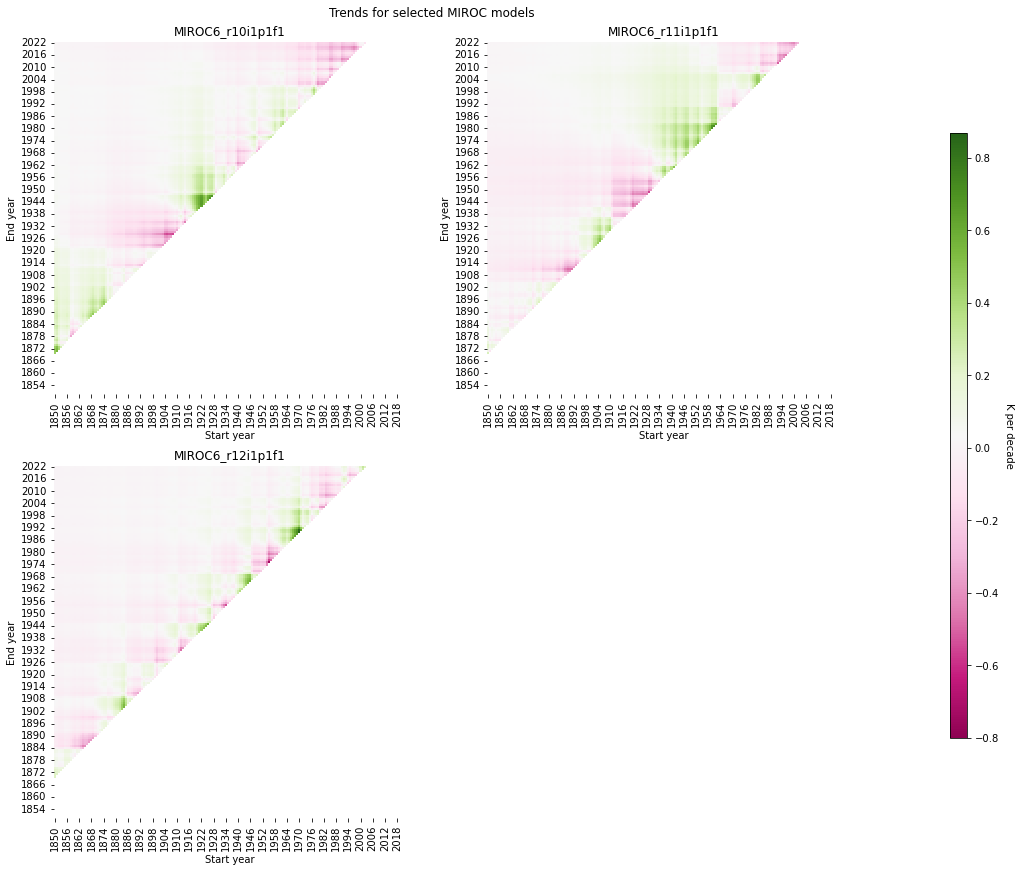

In [32]:
nModels = len(trendsDict)

nCols = 2
if nModels % nCols == 0:
    nRows = int(nModels/nCols)
else:
    nRows = int(np.floor(nModels/nCols) + 1)

subplotSize = (6, 6)
figWidth = nCols * subplotSize[0]
figHeight = nRows * subplotSize[1]

fig = plt.figure(figsize = (figWidth, figHeight), constrained_layout = True)
fig.suptitle('Trends for selected MIROC models')
subplot = 0

axesList = []

# NOTE THIS IS TEMP: Based on Ibuki's plots
#vmin = -0.3
#vmax = -vmin

for modelName, value in trendsDict.items():
    subplot += 1
    ax = fig.add_subplot(nRows, nCols, subplot)
    ax.set_aspect('equal')
    trendPlotter = TrendPlotting(trendsDict, modelName, vmin, vmax)
    ax = trendPlotter.PlotTrends(ax)  
    axesList.append(ax)

cbarAx = fig.add_axes([1.1, 0.15, 0.02, 0.7])
sm = plt.cm.ScalarMappable(cmap = 'PiYG', norm = plt.Normalize(vmin = vmin, vmax = vmax))
colorBar = fig.colorbar(sm, cax = cbarAx)
colorBar.set_label('K per decade', rotation = 270, labelpad = 15)

# plt.savefig('BCC_CSM2_MR_ts.png')
plt.show()

In [24]:
trendsDict.keys()

dict_keys(['MIROC6_r10i1p1f1', 'MIROC6_r11i1p1f1', 'MIROC6_r12i1p1f1'])

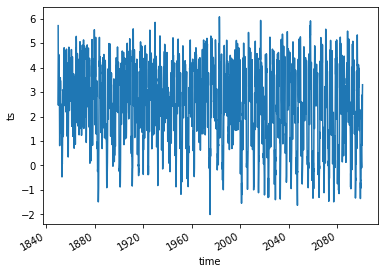

In [99]:
gradDict['MIROC-ES2L_r10i1p1f2'].plot()

In [17]:
# creating a function to extend the period of the model using the scenarios
model = ['http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/CMIP/MIROC/MIROC-ES2L/historical/r10i1p1f2/Amon/ts/gn/v20200318/ts_Amon_MIROC-ES2L_historical_r10i1p1f2_gn_185001-201412.nc']
modelInput = ModelInput(model[0])        

In [18]:
# now we need to find the correct scenario to append to the end of this

# save the source_id of the historical model that we are looking at as a variable
modelHistID = modelInput.ds.attrs['source_id']

# now randomly select one of the models from the same source_id
scenarioRandom = scenarioModels[modelHistID][np.random.randint(0, len(scenarioModels[modelHistID]))]

# now open this dataset to append to the other one; Note that I am going to assume that they are on the same grid for now because they are the same source_id
dsScenario = xr.open_dataset(scenarioRandom)

# concattenating the two datasets
modelFullPeriod = xr.concat([modelInput.ds, dsScenario], dim = 'time')

In [41]:
test = ExtendPeriod(modelInput, scenarioModels)

In [46]:
gradientTest = Gradient(test)

In [59]:
trendTest = Trend(gradientTest)

In [62]:
trendTest.trends[1850,2021]

-0.013791401513850466

In [53]:
gradientTest.gradient.time

<xarray.DataArray 'time' (time: 3012)>
array(['1850-01-16T12:00:00.000000000', '1850-02-15T00:00:00.000000000',
       '1850-03-16T12:00:00.000000000', ..., '2100-10-16T12:00:00.000000000',
       '2100-11-16T00:00:00.000000000', '2100-12-16T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2100-12-16T12:00:00

In [42]:
test

<xarray.Dataset>
Dimensions:    (time: 3012, bnds: 2, lat: 64, lon: 128)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2100-12-16T12:00:00
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 1850-01-01 1850-02-01 ... 2101-01-01
    lat_bnds   (time, lat, bnds) float64 -90.0 -86.58 -86.58 ... 86.58 90.0
    lon_bnds   (time, lon, bnds) float64 -1.406 1.406 1.406 ... 355.8 358.6
    ts         (time, lat, lon) float32 264.7 264.6 264.5 ... 258.0 258.1 258.2
Attributes: (12/45)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            0.0
    branch_time_in_parent:           32871.0
    creation_date:                   2019-12-27T22:27:16Z
    ...                              ...
    variable_id:                     ts
    variant_label:                   r10i1p1f2
    license:                         CMIP6 model data produced by MIROC is li...
    cmor_version:                    3.3.2
    tracking_id:                     hdl:21.14100/f6fce931-3d1d-4396-b418-1e8...
    DODS_EXTRA.Unlimited_Dimension:  time

In [31]:
def ExtendPeriod(modelInput, scenarioModels):
    '''
    Function that takes in the modelInput output and scenarioModels and combines to make one ds that has the full period from the start of the historical model to the end of the scenario model.
    
    Inputs:
        modelInput: an instance of the ModelInput class
        scenarioModels: dictionary of the scenario models labelled with their source_ids
    '''
    
    # save the source_id of the historical model that we are looking at as a variable
    modelHistID = modelInput.ds.attrs['source_id']

    # now randomly select one of the models from the same source_id
    scenarioRandom = scenarioModels[modelHistID][np.random.randint(0, len(scenarioModels[modelHistID]))]

    # now open this dataset to append to the other one; Note that I am going to assume that they are on the same grid for now because they are the same source_id
    dsScenario = xr.open_dataset(scenarioRandom)

    # concattenating the two datasets
    modelFullPeriod = xr.concat([modelInput.ds, dsScenario], dim = 'time')
    
    return modelFullPeriod

In [79]:
scenTest = xr.open_dataset('http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/MIROC/MIROC-ES2L/ssp245/r13i1p1f2/Amon/ts/gn/v20201222/ts_Amon_MIROC-ES2L_ssp245_r13i1p1f2_gn_201501-210012.nc')

In [80]:
scenTest

<xarray.Dataset>
Dimensions:    (time: 1032, bnds: 2, lat: 64, lon: 128)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-16T12:00:00 ... 2100-12-16T12:00:00
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    ts         (time, lat, lon) float32 ...
Attributes: (12/45)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     ScenarioMIP
    branch_method:                   standard
    branch_time_in_child:            60265.0
    branch_time_in_parent:           60265.0
    creation_date:                   2020-11-12T00:44:50Z
    ...                              ...
    variable_id:                     ts
    variant_label:                   r13i1p1f2
    license:                         CMIP6 model data produced by MIROC is li...
    cmor_version:                    3.3.2
    tracking_id:                     hdl:21.14100/44c7b7f3-ed79-4b7d-80a3-433...
    DODS_EXTRA.Unlimited_Dimension:  time

## Checking to see the impact of selection of pathway for this region

Looking at CanESM5 because they have runs for all of the pathways

In [73]:
fileName = 'cmip6_ScenarioMIP_opendap.csv'
inputDf = pd.read_csv(fileName)

# filtering for the subset of links we are interested in
inputDfFilt = inputDf[(inputDf['activity_id'] == 'ScenarioMIP') & 
                      (inputDf['variable_id'] == 'ts') &  
                      (inputDf['source_id'].isin(['CanESM5', 'CNRM-ESM2-1']))
                     ]
# saving all of the urls into one list
modelList = inputDfFilt['URL'].tolist()
modelList = ['http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp119/r10i1p1f1/Amon/ts/gn/v20190429/ts_Amon_CanESM5_ssp119_r10i1p1f1_gn_201501-210012.nc',
             'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp245/r10i1p2f1/Amon/ts/gn/v20190429/ts_Amon_CanESM5_ssp245_r10i1p2f1_gn_201501-210012.nc',
             'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp370/r10i1p1f1/Amon/ts/gn/v20190429/ts_Amon_CanESM5_ssp370_r10i1p1f1_gn_201501-210012.nc',
             'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp460/r5i1p1f1/Amon/ts/gn/v20190429/ts_Amon_CanESM5_ssp460_r5i1p1f1_gn_201501-210012.nc',
             'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp585/r9i1p1f1/Amon/ts/gn/v20190429/ts_Amon_CanESM5_ssp585_r9i1p1f1_gn_201501-210012.nc'
]

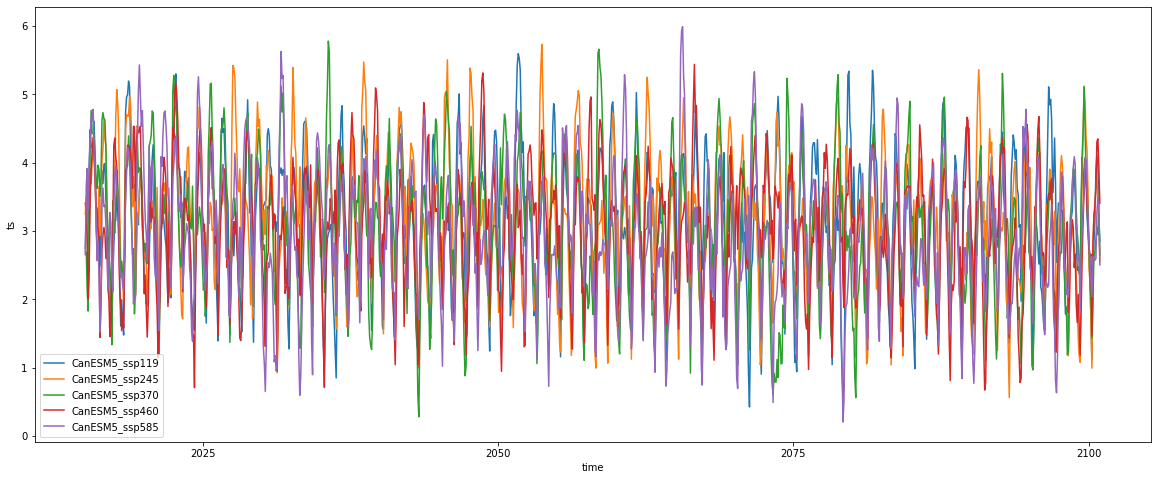

In [74]:
trendsDict = {}
gradDict = {}

fig = plt.figure(figsize = (20,8))

for model in modelList:
    modelInput = ModelInput(model)
    gradientTrend = GradientTrend(modelInput)
    gradientTrend.gradient.plot(label = modelInput.modelName)
    trendsDict[gradientTrend.modelName] = gradientTrend.trends
    gradDict[gradientTrend.modelName] = gradientTrend.gradient
    
plt.legend()
plt.show()

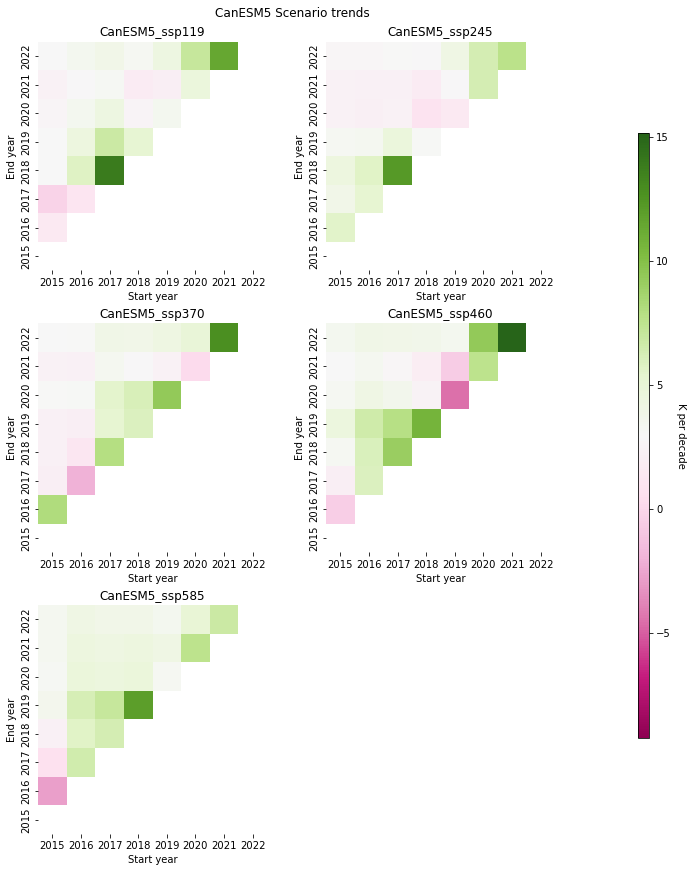

In [76]:
vmin = min(value for innerDict in trendsDict.values() for value in innerDict.values() if not np.isnan(value))
vmax = max(value for innerDict in trendsDict.values() for value in innerDict.values() if not np.isnan(value))

nModels = len(trendsDict)

nCols = 2
if nModels % nCols == 0:
    nRows = int(nModels/nCols)
else:
    nRows = int(np.floor(nModels/nCols) + 1)

subplotSize = (4, 4)
figWidth = nCols * subplotSize[0]
figHeight = nRows * subplotSize[1]

fig = plt.figure(figsize = (figWidth, figHeight), constrained_layout = True)
fig.suptitle('CanESM5 Scenario trends')
subplot = 0

axesList = []

# NOTE THIS IS TEMP: Based on Ibuki's plots
#vmin = -0.3
#vmax = -vmin

for modelName, value in trendsDict.items():
    subplot += 1
    ax = fig.add_subplot(nRows, nCols, subplot)
    ax.set_aspect('equal')
    trendPlotter = TrendPlotting(trendsDict, modelName, vmin, vmax)
    ax = trendPlotter.PlotTrends(ax)  
    axesList.append(ax)

cbarAx = fig.add_axes([1.1, 0.15, 0.02, 0.7])
sm = plt.cm.ScalarMappable(cmap = 'PiYG', norm = plt.Normalize(vmin = vmin, vmax = vmax))
colorBar = fig.colorbar(sm, cax = cbarAx)
colorBar.set_label('K per decade', rotation = 270, labelpad = 15)

plt.savefig('CanESM5 Scenario Trends.png')
plt.show()